scale_factor_target_width: 4.0, scale_factor_target_height: 4.0
scale_factor_source_width: 0.25, scale_factor_source_height: 0.25
0,0.8297858,0.4942768,0.8327726,0.6240648

t_lm: (852, 639), s_lm: (849, 506)
1,0.8376008,0.5077555,0.8403689,0.6374664

t_lm: (860, 652), s_lm: (857, 519)
2,0.8517599,0.519607,0.8468537,0.6419535

t_lm: (867, 657), s_lm: (872, 532)
3,0.8646076,0.5144064,0.8534143,0.6446626

t_lm: (873, 660), s_lm: (885, 526)
4,0.8702048,0.5029821,0.8635899,0.6405838

t_lm: (884, 655), s_lm: (891, 515)
5,0.8720134,0.495777,0.8769266,0.6256475

t_lm: (897, 640), s_lm: (892, 507)
6,0.874122,0.486209,0.8833104,0.606265

t_lm: (904, 620), s_lm: (895, 497)
7,0.8740584,0.4748318,0.8917425,0.574199

t_lm: (913, 587), s_lm: (895, 486)
8,0.8704417,0.4521865,0.8816165,0.5374848

t_lm: (902, 550), s_lm: (891, 463)
9,0.8647426,0.4367807,0.8734589,0.5122804

t_lm: (894, 524), s_lm: (885, 447)
10,0.8590185,0.4250501,0.8622392,0.4897257

t_lm: (882, 501), s_lm: (879, 435)
11,0.8514037,0.41

c:\Users\joeli\miniforge3\envs\torch_311\Lib\site-packages\google\protobuf\symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


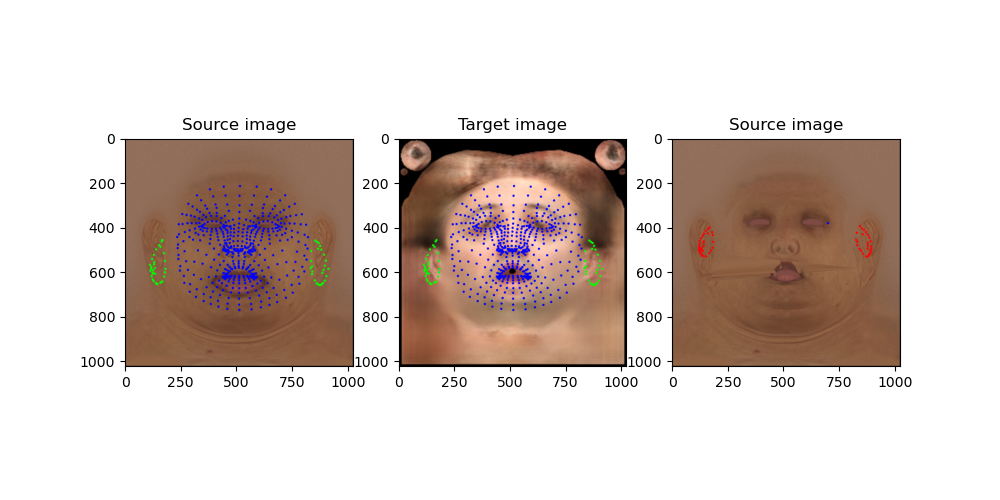

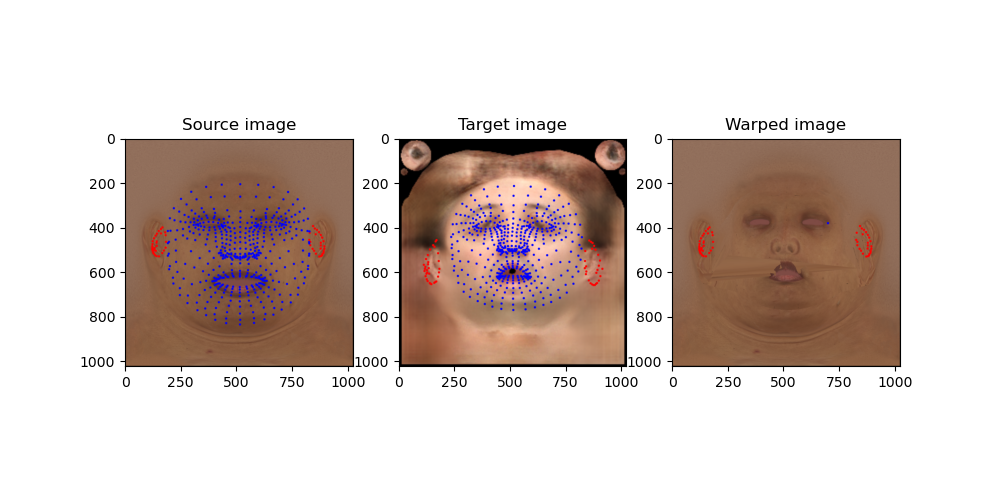

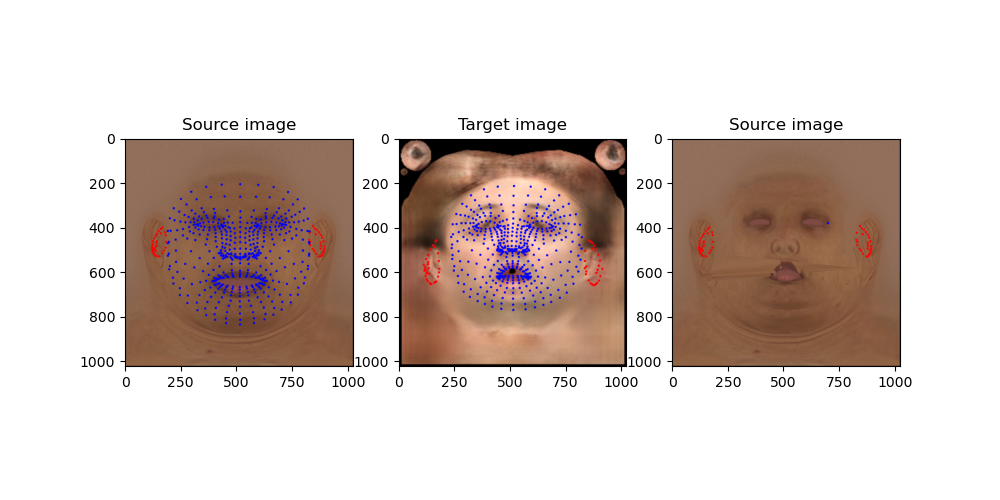

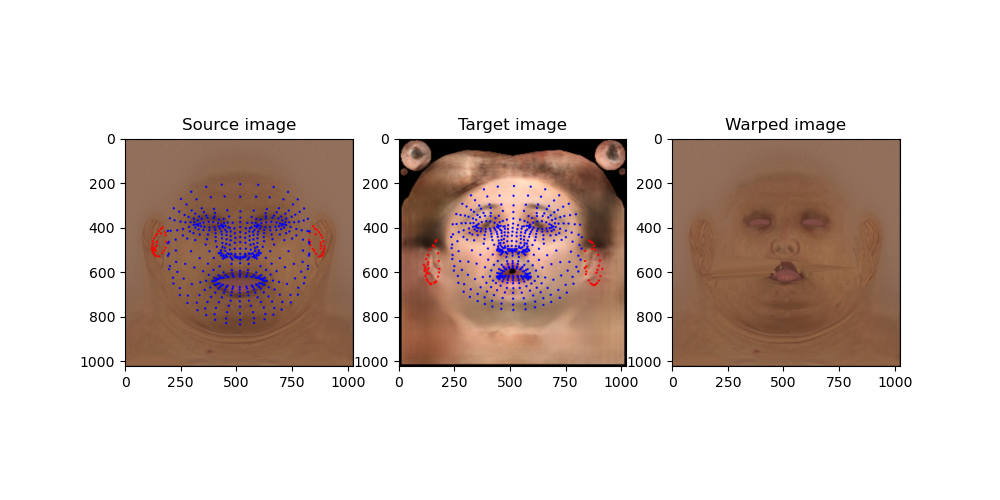

In [18]:
import sys
from pathlib import Path

from scipy.spatial import Delaunay
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

def get_landmarks(image):
    print("Getting landmarks")
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for i in range(0, 468):
                print(f"landmark {i}: {face_landmarks.landmark[i]}")
                landmark = face_landmarks.landmark[i]
                x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
                landmarks.append((x, y))
    if len(landmarks) == 0:
        print("No landmarks found")
        return None
    return np.array(landmarks)


def get_extended_landmarks(landmarks, image_shape):
    hull = cv2.convexHull(landmarks)
    offset = 0
    boundary_points = np.array([
        [offset, offset],
        [image_shape[1] // 2, offset],
        [image_shape[1] - 1 - offset, offset],
        [image_shape[1] - 1 - offset, image_shape[0] // 2],
        [image_shape[1] - 1 - offset, image_shape[0] - 1 - offset],
        [image_shape[1] // 2, image_shape[0] - 1 - offset],
        [offset, image_shape[0] - 1 - offset],
        [offset, image_shape[0] // 2]
    ])
    extended_landmarks = np.vstack((landmarks, boundary_points))
    extended_landmarks = np.vstack((extended_landmarks, hull.squeeze()))
    return extended_landmarks

def warp_image(target, source, landmarks1, landmarks2):
    landmarks1_extended = get_extended_landmarks(landmarks1, target.shape)[:-2]
    landmarks2_extended = get_extended_landmarks(landmarks2, source.shape)[:-2]
    landmarks1_extended = np.array(landmarks1)
    landmarks2_extended = np.array(landmarks2)
    delaunay = Delaunay(landmarks1_extended)
    warped_image = target.copy()
    transformation_matrices = []
    # Iterate through each triangle
    for simplex in delaunay.simplices[:-1]:
        if np.any(simplex >= len(landmarks1)) or np.any(simplex >= len(landmarks2)):
            continue
        src_triangle = landmarks1_extended[simplex]
        dest_triangle = landmarks2_extended[simplex]
        src_rect = cv2.boundingRect(np.float32([src_triangle]))
        dest_rect = cv2.boundingRect(np.float32([dest_triangle]))
        src_cropped_triangle = target[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]]
        dest_cropped_triangle = np.zeros((dest_rect[3], dest_rect[2], 3), dtype=np.float32)
        src_triangle_adjusted = src_triangle - (src_rect[0], src_rect[1])
        dest_triangle_adjusted = dest_triangle - (dest_rect[0], dest_rect[1])
        matrix = cv2.getAffineTransform(np.float32(src_triangle_adjusted), np.float32(dest_triangle_adjusted))
        warped_triangle = cv2.warpAffine(src_cropped_triangle, matrix, (dest_rect[2], dest_rect[3]))
        mask = np.zeros((dest_rect[3], dest_rect[2]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dest_triangle_adjusted), (1, 1, 1), 16, 0)
        warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] * (1 - mask[:, :, None]) \
            + warped_triangle * mask[:, :, None]
        transformation_matrices.append((matrix, src_triangle, dest_triangle))
    return warped_image.astype(np.uint8), delaunay, transformation_matrices


def warp_image2(target, source, landmarks1, landmarks2):
    # landmarks1_extended = get_extended_landmarks(landmarks1, target.shape)[:-2]
    # landmarks2_extended = get_extended_landmarks(landmarks2, source.shape)[:-2]
    delaunay = Delaunay(landmarks1_extended)
    warped_image_with_bg = target.copy()
    warped_image_no_bg = np.zeros_like(target)
    transformation_matrices = []

    for simplex in delaunay.simplices[:-1]:
        if np.any(simplex >= len(landmarks1)) or np.any(simplex >= len(landmarks2)):
            continue

        src_triangle = landmarks1_extended[simplex]
        dest_triangle = landmarks2_extended[simplex]
        src_rect = cv2.boundingRect(np.float32([src_triangle]))
        dest_rect = cv2.boundingRect(np.float32([dest_triangle]))

        src_cropped_triangle = target[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]]
        dest_cropped_triangle = np.zeros((dest_rect[3], dest_rect[2], 3), dtype=np.float32)

        src_triangle_adjusted = src_triangle - (src_rect[0], src_rect[1])
        dest_triangle_adjusted = dest_triangle - (dest_rect[0], dest_rect[1])

        matrix = cv2.getAffineTransform(np.float32(src_triangle_adjusted), np.float32(dest_triangle_adjusted))
        warped_triangle = cv2.warpAffine(src_cropped_triangle, matrix, (dest_rect[2], dest_rect[3]))

        mask = np.zeros((dest_rect[3], dest_rect[2]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dest_triangle_adjusted), (1, 1, 1), 16, 0)

        # Apply to image with background
        warped_image_with_bg[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            warped_image_with_bg[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] * (1 - mask[:, :, None]) \
            + warped_triangle * mask[:, :, None]

        # Apply to image without background
        warped_image_no_bg[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            warped_image_no_bg[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] * (1 - mask[:, :, None]) \
            + warped_triangle * mask[:, :, None]

        transformation_matrices.append((matrix, src_triangle, dest_triangle))

    return warped_image_with_bg.astype(np.uint8), warped_image_no_bg.astype(np.uint8), delaunay, transformation_matrices

def apply_transformations_to_single_channel_image(original_image, transformation_matrices):
    warped_image = np.zeros(original_image.shape, dtype=np.uint8)
    for matrix, src_triangle, dest_triangle in transformation_matrices:
        dest_rect = cv2.boundingRect(np.float32([dest_triangle]))
        cropped_region = original_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]]
        dest_triangle_adjusted = dest_triangle - (dest_rect[0], dest_rect[1])
        # Compute the affine transformation
        matrix_inv = cv2.invertAffineTransform(matrix)
        # Warp the corresponding region to the shape of the source triangle
        warped_region = cv2.warpAffine(cropped_region, matrix_inv, (dest_rect[2], dest_rect[3]), None, 
                                       flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        # Mask for the source triangle
        mask = np.zeros((dest_rect[3], dest_rect[2]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dest_triangle_adjusted), 1, 16)
        # Place the warped region in the warped image
        warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] * (1 - mask) + \
            warped_region * mask
    return warped_image

def morph_images(example_image_path, target_image_path,width, height):
    print(f"morphing {example_image_path} to {target_image_path}")
    
    example_image_path = str(example_image_path)
    target_image_path = str(target_image_path)
    try:
        target_image = cv2.imread(target_image_path)
        target_image = cv2.resize(target_image, (width, height),interpolation=cv2.INTER_LANCZOS4)
    except:
        print(f"Error: could not read source image {example_image_path}")
        sys.exit()
    try:
        example_image = cv2.imread(example_image_path)
        example_image = cv2.resize(example_image, (width, height),interpolation=cv2.INTER_LANCZOS4)
    except:
        print(f"Error: could not read source image {example_image_path}")
        sys.exit()
    # landmarks1 = get_landmarks(example_image)
    # landmarks2 = get_landmarks(target_image)
    # warped_example_image, delaunay, transformation_matrices = warp_image(example_image, target_image,landmarks1, landmarks2)
    # return warped_example_image, target_image
    return example_image, target_image
if __name__ == '__main__':

    # ma "D:\Unity Projects\flame\Assets\33346.png"
    # mb ""D:\Unity Projects\flame\Assets\m46_4k.png""
    # target_image_path = r"C:\Users\joeli\Dropbox\Data\models_4k\light\m32_4k.png"
    # source_image_path = r"C:\Users\joeli\Dropbox\Data\face_image_data\facescape\2\models_reg\1_neutral.jpg"
   
    
    target_image_path = r"D:\Unity Projects\flame\Assets\33346.png"
    source_image_path = r"D:\Unity Projects\flame\Assets\m46_4k.png"
    target_image = cv2.imread(target_image_path)
    source_image = cv2.imread(source_image_path)
    
    WIDTH = 1024
    HEIGHT = 1024
    # Original sizes
    original_target_width, original_target_height = target_image.shape[1], target_image.shape[0]
    original_source_width, original_source_height = source_image.shape[1], source_image.shape[0]

    # Calculate scaling factors
    scale_factor_target_width = WIDTH / original_target_width 
    scale_factor_target_height = HEIGHT / original_target_height
    scale_factor_source_width = WIDTH / original_source_width
    scale_factor_source_height = HEIGHT / original_source_height
    print(f"scale_factor_target_width: {scale_factor_target_width}, scale_factor_target_height: {scale_factor_target_height}")
    print(f"scale_factor_source_width: {scale_factor_source_width}, scale_factor_source_height: {scale_factor_source_height}")
    target_image = cv2.resize(target_image, (WIDTH, HEIGHT))
    source_image = cv2.resize(source_image, (WIDTH, HEIGHT))

    if source_image is None or target_image is None:
        print("Error: could not read one of the images.")
        # Handle the error, for example by exiting the script
        sys.exit()

    # load landmarks
    #m1 is target
    #m2 is source
    # i,u1,v1,u2,v2
    # 0,0.4945696,0.5239752,0.5040277,0.5081507
    # 1,0.6577965,0.5985687,0.6957955,0.6291448
    # 2,0.573979,0.6166188,0.5784552,0.6308378 ...
    landmarks_path = r"D:\Unity Projects\flame\Assets\points.txt"
    #read each row 
    target_landmarks = []
    source_landmarks = []
    WIDTH = 1024
    HEIGHT = 1024
    with open(landmarks_path, "r") as file:
        for line in file:
            if line.startswith("#"):
                continue
            if line.startswith("i"):
                continue
            print(line)
            i,u1,v1,u2,v2 = line.split(",")
            s_lm = (int(float(u1)*WIDTH), int(float(v1)*HEIGHT))
            t_lm = (int(float(u2)*WIDTH), int(float(v2)*HEIGHT))
            # #mirrored
            # sm_lm = (WIDTH - s_lm[0], s_lm[1])
            # tm_lm = (WIDTH - t_lm[0], t_lm[1])
            

            print(f"t_lm: {t_lm}, s_lm: {s_lm}")
            target_landmarks.append(t_lm)
            source_landmarks.append(s_lm)
            # target_landmarks.append(tm_lm)
            # source_landmarks.append(sm_lm)
            # i,u1,v1,u2,v2 = line.split()
            # print(i,u1,v1,u2,v2)
            # landmarks.append((int(u1), int(v1)))
            # x, y = line.split()
            # landmarks.append((int(x), int(y)))
    target_landmarks2 = get_landmarks(target_image)
    source_landmarks2 = get_landmarks(source_image)

    if target_landmarks2 is None or source_landmarks2 is None:
        print("Error: could not get landmarks for one of the images.")
        # Handle the error, for example by exiting the script
        sys.exit()
    #    #combine the landmarks
    target_lm_combined = np.vstack((target_landmarks, target_landmarks2))
    source_lm_combined = np.vstack((source_landmarks, source_landmarks2))
    print(f"target_landmarks: {np.asarray(target_landmarks).shape}, target_landmarks2: {np.asarray(target_landmarks2).shape}")
    print(f"source_landmarks: {np.asarray(source_landmarks).shape}, source_landmarks2: {np.asarray(source_landmarks2).shape}")
    # print lm 2
    print(f"target_landmarks2: {target_landmarks2.shape}, source_landmarks2: {source_landmarks2.shape}")
    
    print(f"target_lm_combined: {target_lm_combined.shape}, source_lm_combined: {source_lm_combined.shape}")
    print(f"target_landmarks_combined: {target_lm_combined.shape}, source_landmarks_combined: {source_lm_combined.shape}")
    #combined shape
    print(f"target_landmarks_combined: {target_lm_combined.shape}, source_landmarks_combined: {source_lm_combined.shape}")
    annotated_target_image = target_image.copy()
    annotated_source_image = source_image.copy()
    warped_source_image, delaunay, transformation_matrices = warp_image(source_image, target_image, source_lm_combined, target_lm_combined)
    warpped_annnotated_source_image = warped_source_image.copy()
    for i , x1,y1, x2, y2 in zip(range(len(target_lm_combined)), target_lm_combined[:,0], target_lm_combined[:,1], source_lm_combined[:,0], source_lm_combined[:,1]):
        source_x, source_y = source_lm_combined[i]
        
        target_x, target_y = target_lm_combined[i]

        lm_str = f"{i} ({x1},{y1}) -> ({x2},{y2})"
        print(lm_str)

        # check if its from target_landmarks or target_landmarks2
        offset = len(target_landmarks)
        if i < offset:
            #red for target landmarks 
            cv2.circle(annotated_target_image, (target_x, target_y), 5, (0, 0, 255), -1)
            cv2.circle(annotated_source_image, (source_x, source_y), 5, (0, 0, 255), -1)
            cv2.circle(warpped_annnotated_source_image, (source_x, source_y), 5, (0, 0, 255), -1)
        else:
            #blue for target landmarks 2
            cv2.circle(annotated_target_image, (target_x, target_y), 5, (255, 0, 0), -1)
            cv2.circle(annotated_source_image, (source_x, source_y), 5, (255, 0, 0), -1)
            cv2.circle(warpped_annnotated_source_image, (x, y), 5, (255, 0, 0), -1)
            
        # cv2.putText(annotated_target_image, str(lm_str), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
    plt.imshow(cv2.cvtColor(warpped_annnotated_source_image, cv2.COLOR_BGR2RGB))
    plt.title("Source image")
    plt.show()

  
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(annotated_source_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Source image")
    ax[1].imshow(cv2.cvtColor(annotated_target_image, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Target image")
    #warpped annnotated source image
    ax[2].imshow(cv2.cvtColor(warpped_annnotated_source_image, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Warped image")
    plt.show()
    

    plt.imshow(cv2.cvtColor(warpped_annnotated_source_image, cv2.COLOR_BGR2RGB))
    plt.title("Source image")
    plt.show()
    plt.imshow(cv2.cvtColor(warped_source_image, cv2.COLOR_BGR2RGB))
    plt.title("Warped image")
    plt.show()
    #save the warped image as 1024x1024
    cv2.imwrite("warped_source_image.png", warped_source_image)
    #apply the transformation to the landmarks
    

    


In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import cv2
import sys

# Define a function to update the landmark positions
def update_landmark_positions(change):
    idx = change['owner'].landmark_index
    pos = change['new']
    if change['owner'].is_target:
        target_lm_combined[idx] = pos
        target_circles[idx].center = pos
    else:
        source_lm_combined[idx] = pos
        source_circles[idx].center = pos
    fig.canvas.draw_idle()

# Create a function to create sliders and associate them with landmarks
def create_sliders(landmarks, is_target=True):
    sliders = []
    for i, (x, y) in enumerate(landmarks):
        x_slider = widgets.FloatSlider(min=0, max=WIDTH-1, step=1, value=x, description=f'X{i}')
        y_slider = widgets.FloatSlider(min=0, max=HEIGHT-1, step=1, value=y, description=f'Y{i}')
        x_slider.landmark_index = i
        y_slider.landmark_index = i
        x_slider.is_target = is_target
        y_slider.is_target = is_target
        x_slider.observe(update_landmark_positions, names='value')
        y_slider.observe(update_landmark_positions, names='value')
        sliders.extend([x_slider, y_slider])
    return sliders

# Define a function to draw the initial landmarks
def draw_landmarks(ax, landmarks, edge_color):
    circles = []
    for x, y in landmarks:
        circle = Circle((x, y), radius=5, edgecolor=edge_color, facecolor='none')
        ax.add_patch(circle)
        circles.append(circle)
    return circles

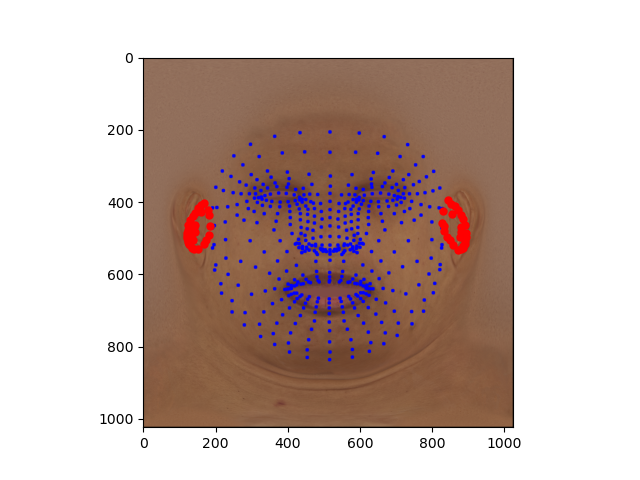

AttributeError: 'Line2D' object has no attribute 'center'

AttributeError: 'Line2D' object has no attribute 'center'

AttributeError: 'Line2D' object has no attribute 'center'

In [23]:
from matplotlib.patches import Circle

class DraggablePoint:
    def __init__(self, artist):
        self.artist = artist
        self.press = None

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.artist.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.artist.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.artist.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.artist.axes: return
        contains, attrd = self.artist.contains(event)
        if not contains: return
        self.press = self.artist.center, event.xdata, event.ydata

    def on_motion(self, event):
        if self.press is None: return
        if event.inaxes != self.artist.axes: return
        x0, y0 = self.press
        dx = event.xdata - x0
        dy = event.ydata - y0
        self.artist.center = x0+dx, y0+dy
        self.artist.figure.canvas.draw()

    def on_release(self, event):
        'on release we reset the press data'
        self.press = None
        self.artist.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.artist.figure.canvas.mpl_disconnect(self.cidpress)
        self.artist.figure.canvas.mpl_disconnect(self.cidrelease)
        self.artist.figure.canvas.mpl_disconnect(self.cidmotion)
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(annotated_source_image, cv2.COLOR_BGR2RGB))

points = source_landmarks  # Assuming this is a list of (x, y) tuples
draggable_points = []
for x, y in points:
    point, = ax.plot(x, y, 'o', color='red', markersize=10)
    dp = DraggablePoint(point)
    dp.connect()
    draggable_points.append(dp)

plt.show()
# Display the images with landmarks
# ax[0].imshow(cv2.cvtColor(annotated_source_image, cv2.COLOR_BGR2RGB))
# ax[0].set_title("Source image")
# ax[1].imshow(cv2.cvtColor(annotated_target_image, cv2.COLOR_BGR2RGB))
# ax[1].set_title("Target image")
# ax[2].imshow(cv2.cvtColor(warped_source_image, cv2.COLOR_BGR2RGB))
# ax[2].set_title("Warped image")
#render 3d model
# object_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\flame_feb_2024\temp\objects\jj.obj"
# render object with warped image as texture



scale_factor_target_width: 4.0, scale_factor_target_height: 4.0
scale_factor_source_width: 0.25, scale_factor_source_height: 0.25
0,0.8297858,0.4942768,0.8327726,0.6240648

t_lm: (852, 639), s_lm: (849, 506)
1,0.8376008,0.5077555,0.8403689,0.6374664

t_lm: (860, 652), s_lm: (857, 519)
2,0.8517599,0.519607,0.8468537,0.6419535

t_lm: (867, 657), s_lm: (872, 532)
3,0.8646076,0.5144064,0.8534143,0.6446626

t_lm: (873, 660), s_lm: (885, 526)
4,0.8702048,0.5029821,0.8635899,0.6405838

t_lm: (884, 655), s_lm: (891, 515)
5,0.8720134,0.495777,0.8769266,0.6256475

t_lm: (897, 640), s_lm: (892, 507)
6,0.874122,0.486209,0.8833104,0.606265

t_lm: (904, 620), s_lm: (895, 497)
7,0.8740584,0.4748318,0.8917425,0.574199

t_lm: (913, 587), s_lm: (895, 486)
8,0.8704417,0.4521865,0.8816165,0.5374848

t_lm: (902, 550), s_lm: (891, 463)
9,0.8647426,0.4367807,0.8734589,0.5122804

t_lm: (894, 524), s_lm: (885, 447)
10,0.8590185,0.4250501,0.8622392,0.4897257

t_lm: (882, 501), s_lm: (879, 435)
11,0.8514037,0.41

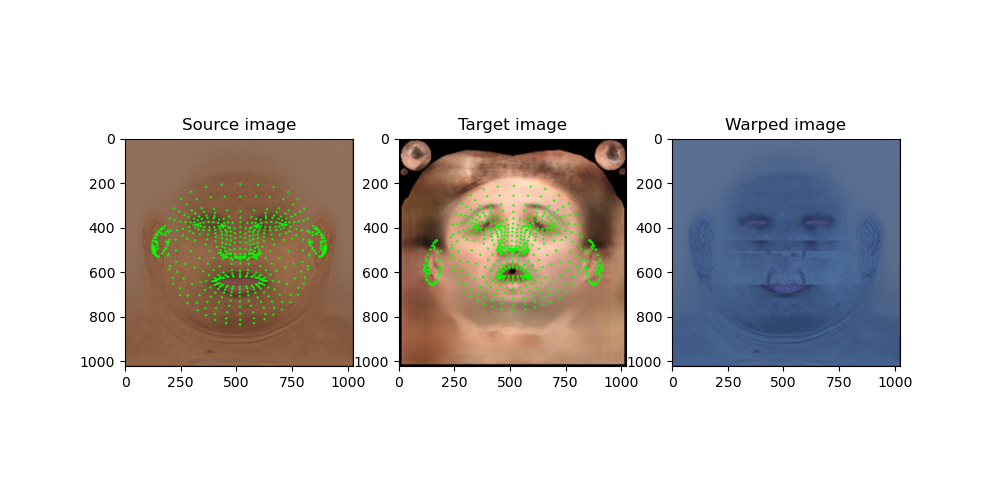

(array([[[ 14,  16,  29],
         [ 67,  74, 121],
         [ 67,  74, 121],
         ...,
         [ 67,  74, 121],
         [ 67,  74, 121],
         [ 28,  31,  50]],
 
        [[ 16,  18,  31],
         [ 67,  74, 121],
         [ 68,  74, 121],
         ...,
         [ 67,  74, 121],
         [ 67,  74, 121],
         [ 29,  32,  53]],
 
        [[ 22,  27,  37],
         [ 90, 109, 143],
         [ 90, 109, 144],
         ...,
         [ 90, 109, 144],
         [ 90, 109, 143],
         [ 22,  27,  37]],
 
        ...,
 
        [[ 17,  25,  38],
         [ 71, 101, 146],
         [ 71, 102, 147],
         ...,
         [ 70, 100, 146],
         [ 71, 101, 145],
         [ 17,  25,  38]],
 
        [[ 12,  18,  28],
         [ 71, 102, 146],
         [ 70, 100, 144],
         ...,
         [ 70,  99, 144],
         [ 71, 102, 146],
         [ 12,  18,  28]],
 
        [[  0,   0,   0],
         [ 12,  18,  28],
         [ 16,  25,  37],
         ...,
         [ 16,  25,  37],
  

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

class DraggablePoints:
    def __init__(self, ax, points):
        self.ax = ax
        self.points = points
        self.circles = [ax.add_patch(Circle((x, y), radius=5, edgecolor='red', facecolor='none')) for x, y in points]
        self.selected = None  # Index of the selected point
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidmotion = self.ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.cidrelease = self.ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_press(self, event):
        for i, circle in enumerate(self.circles):
            contains, _ = circle.contains(event)
            if contains:
                self.selected = i
                return  # Stop checking after the first match

    def on_motion(self, event):
        if self.selected is not None:
            x, y = event.xdata, event.ydata
            circle = self.circles[self.selected]
            circle.center = x, y
            self.points[self.selected] = [x, y]
            self.ax.figure.canvas.draw_idle()

    def on_release(self, event):
        self.selected = None

target_image_path = r"D:\Unity Projects\flame\Assets\33346.png"
source_image_path = r"D:\Unity Projects\flame\Assets\m46_4k.png"
target_image = cv2.imread(target_image_path)
source_image = cv2.imread(source_image_path)

WIDTH = 1024
HEIGHT = 1024
# Original sizes
original_target_width, original_target_height = target_image.shape[1], target_image.shape[0]
original_source_width, original_source_height = source_image.shape[1], source_image.shape[0]

# Calculate scaling factors
scale_factor_target_width = WIDTH / original_target_width 
scale_factor_target_height = HEIGHT / original_target_height
scale_factor_source_width = WIDTH / original_source_width
scale_factor_source_height = HEIGHT / original_source_height
print(f"scale_factor_target_width: {scale_factor_target_width}, scale_factor_target_height: {scale_factor_target_height}")
print(f"scale_factor_source_width: {scale_factor_source_width}, scale_factor_source_height: {scale_factor_source_height}")
target_image = cv2.resize(target_image, (WIDTH, HEIGHT))
source_image = cv2.resize(source_image, (WIDTH, HEIGHT))

if source_image is None or target_image is None:
    print("Error: could not read one of the images.")
    # Handle the error, for example by exiting the script
    sys.exit()

# load landmarks
#m1 is target
#m2 is source
# i,u1,v1,u2,v2
# 0,0.4945696,0.5239752,0.5040277,0.5081507
# 1,0.6577965,0.5985687,0.6957955,0.6291448
# 2,0.573979,0.6166188,0.5784552,0.6308378 ...
landmarks_path = r"D:\Unity Projects\flame\Assets\points.txt"
#read each row 
target_landmarks = []
source_landmarks = []
WIDTH = 1024
HEIGHT = 1024
with open(landmarks_path, "r") as file:
    for line in file:
        if line.startswith("#"):
            continue
        if line.startswith("i"):
            continue
        print(line)
        i,u1,v1,u2,v2 = line.split(",")
        s_lm = (int(float(u1)*WIDTH), int(float(v1)*HEIGHT))
        t_lm = (int(float(u2)*WIDTH), int(float(v2)*HEIGHT))
        #mirrored
        sm_lm = (WIDTH - s_lm[0], s_lm[1])
        tm_lm = (WIDTH - t_lm[0], t_lm[1])
        

        print(f"t_lm: {t_lm}, s_lm: {s_lm}")
        target_landmarks.append(t_lm)
        source_landmarks.append(s_lm)
        target_landmarks.append(tm_lm)
        source_landmarks.append(sm_lm)
        # i,u1,v1,u2,v2 = line.split()
        # print(i,u1,v1,u2,v2)
        # landmarks.append((int(u1), int(v1)))
        # x, y = line.split()
        # landmarks.append((int(x), int(y)))
target_landmarks2 = get_landmarks(target_image)
source_landmarks2 = get_landmarks(source_image)

if target_landmarks2 is None or source_landmarks2 is None:
    print("Error: could not get landmarks for one of the images.")
    # Handle the error, for example by exiting the script
    sys.exit()
#    #combine the landmarks
target_lm_combined = np.vstack((target_landmarks, target_landmarks2))
source_lm_combined = np.vstack((source_landmarks, source_landmarks2))
# Sample points
source_points = source_lm_combined
target_points = target_lm_combined
annotated_source_image = source_image.copy()
annotated_target_image = target_image.copy()
for i in range(len(source_lm_combined)):
    annotated_source_image = cv2.circle(annotated_source_image, (source_lm_combined[i][0], source_lm_combined[i][1]), 5, (0, 255, 0), -1)
    annotated_target_image = cv2.circle(annotated_target_image, (target_lm_combined[i][0], target_lm_combined[i][1]), 5, (0, 255, 0), -1)
    
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(annotated_source_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Source image")
ax[1].imshow(cv2.cvtColor(annotated_target_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Target image")
warped_image, delaunay, transformation_matrices = warp_image(source_image, target_image, source_landmarks, target_landmarks)

ax[2].imshow(warped_image)
ax[2].set_title("Warped image")
plt.show()
warped_image, delaunay, transformation_matrices



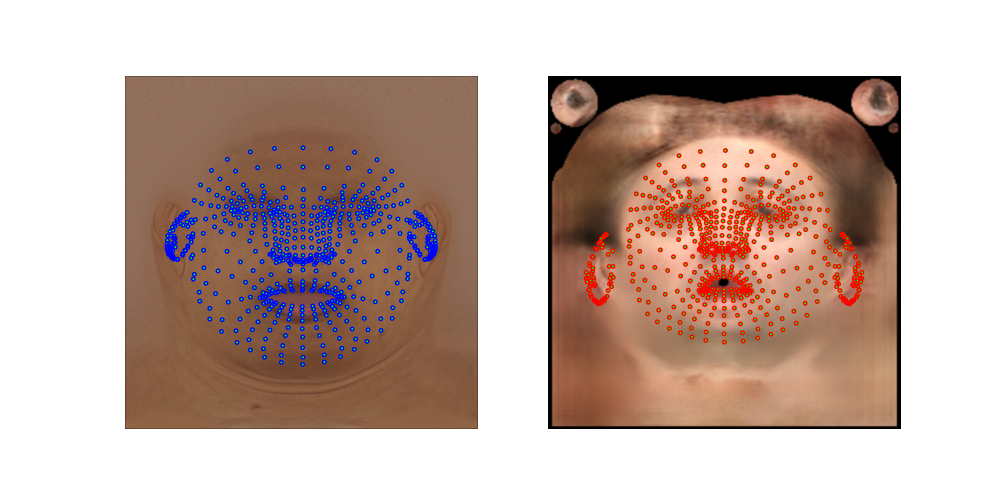

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

class DraggablePoints:
    """A class to drag and update points on a matplotlib plot."""
    def __init__(self, ax, points, radius=5, edgecolor='red', facecolor='none', zorder=2):
        self.ax = ax
        self.points = points
        self.circles = [ax.add_patch(Circle(point, radius=radius, edgecolor=edgecolor,
                                            facecolor=facecolor, zorder=zorder)) for point in points]
        self.selected = None  # Index of the selected point
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidmotion = self.ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.cidrelease = self.ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_press(self, event):
        """Executes when the mouse button is pressed."""
        for i, circle in enumerate(self.circles):
            contains, _ = circle.contains(event)
            if contains:
                self.selected = i
                return  # Stop checking after the first match

    def on_motion(self, event):
        """Executes when the mouse is moved (with button pressed)."""
        if self.selected is not None and event.xdata is not None and event.ydata is not None:
            new_center = (event.xdata, event.ydata)
            self.circles[self.selected].center = new_center
            self.points[self.selected] = new_center
            self.ax.figure.canvas.draw_idle()

    def on_release(self, event):
        """Executes when the mouse button is released."""
        self.selected = None
# Create the figure and axes for the subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the images
ax[0].imshow(cv2.cvtColor(annotated_source_image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')  # Turn off the axis
ax[1].imshow(cv2.cvtColor(annotated_target_image, cv2.COLOR_BGR2RGB))
ax[1].axis('off')

# Create draggable points for the source and target images
source_draggable_points = DraggablePoints(ax[0], source_lm_combined, edgecolor='blue')
target_draggable_points = DraggablePoints(ax[1], target_lm_combined, edgecolor='red')

plt.show()

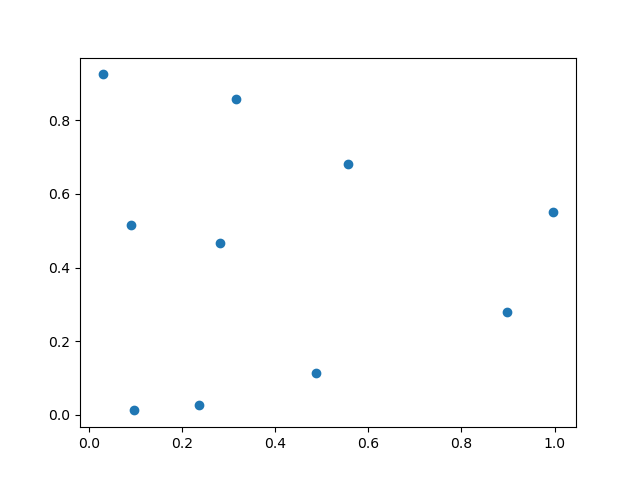

In [12]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

class DraggablePoints:
    def __init__(self, points):
        self.points = points
        self.fig, self.ax = plt.subplots()
        self.scatter = self.ax.scatter(points[:, 0], points[:, 1])
        self.cid = self.scatter.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        if event.inaxes != self.scatter.axes: return
        contains, ind = self.scatter.contains(event)
        if not contains: return
        self.current_point = ind['ind'][0]
        self.scatter.figure.canvas.mpl_connect('motion_notify_event', self.drag)

    def drag(self, event):
        if event.inaxes != self.scatter.axes: return
        self.points[self.current_point] = [event.xdata, event.ydata]
        self.scatter.set_offsets(self.points)
        self.scatter.figure.canvas.draw()

    def disconnect(self):
        self.scatter.figure.canvas.mpl_disconnect(self.cid)

points = np.random.rand(10, 2)
draggable_points = DraggablePoints(points)
plt.show()

